In [1]:
# This script aims to simulate a quantum circuit that mimics aspects of Grover's
# algorithm, specifically involving multi-level quantum systems (qudits) and
# custom gates. It then visualizes the measurement outcomes using a histogram.

import cirq
import numpy as np
import cmath
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# --- Configuration for the Circuit ---
# Define the dimension of the qudit system.
# The current implementation uses d=4 for a 4-dimensional Hilbert space.
QU_DIMENSION = 4

# Define the number of qubits (or qudits in this case).
# The current circuit operates on two qudits.
NUM_QUDITS = 2

# Define the number of repetitions for the simulation.
# A higher number of repetitions leads to a more accurate histogram.
SIMULATION_REPETITIONS = 5000

In [3]:
# --- Gate Definitions ---

# The `matrices()` function generates the unitary matrices for the U0 and Uf gates.
# These are fundamental to Grover's algorithm:
# - U0 (Oracle): Marks the desired state by flipping its phase.
# - Uf (Diffusion/Amplification): Amplifies the marked state's amplitude.

In [4]:
# Defining U0 and Uf matrices

def matrices():
    """Generates the unitary matrices for the U0 and Uf gates.

    These matrices are designed to mimic the oracle (U0) and diffusion/amplification
    operator (Uf) in Grover's algorithm, operating within a 16-dimensional Hilbert space.

    U0: Flips the phase of the |0> state (all qubits in |0>).
        In this context, it's applied to a 16-dimensional space.
    Uf: Marks a specific state (index 4 in the 16-dim space) by flipping its phase.

    Returns:
        tuple: A tuple containing two numpy arrays: (U0_arr, Uf_arr).
    """
    # The identity matrix for a 16-dimensional space.
    # This space is assumed to be the tensor product of QU_DIMENSION^NUM_QUDITS states.
    # Here, 4^2 = 16.
    U0_arr = np.identity(QU_DIMENSION**NUM_QUDITS, dtype=complex)
    Uf_arr = np.identity(QU_DIMENSION**NUM_QUDITS, dtype=complex)

    # U0: Flip the phase of the |0...0> state (the first basis vector).
    U0_arr[0, 0] = -1

    # Uf: Mark a specific state by flipping its phase.
    # The 'positions' variable determines which state is marked.
    # Currently hardcoded to index 4. This is a simplification for the example.
    positions = [4] # Index of the state to be marked by Uf
    for elem1 in positions:
        Uf_arr[elem1, elem1] = -Uf_arr[elem1, elem1]

    return U0_arr, Uf_arr

In [5]:
# Generate the U0 and Uf matrices globally for use in gate definitions.
U0_arr, Uf_arr = matrices()

In [6]:
# Qudit Hadamard Gate
class QuditHGate(cirq.Gate):
    """A generalized Hadamard-like gate for qudits.

    This gate acts on a single d-level system (qudit).
    It implements a specific unitary transformation, which in the original
    example was a normalized DFT matrix. For this script's purpose,
    we assume it's a component for setting up the search space.

    Args:
        d (int): The number of levels in the qudit system.
                 This dictates the dimension of the Hilbert space.
    """
    def __init__(self, d: int):
        """Initializes the QuditHGate for a qudit of 'd' levels."""
        super().__init__()
        if not isinstance(d, int) or d <= 0:
            raise ValueError("The number of levels 'd' must be a positive integer.")
        self._d = d
        self.name = f'Qu{d}H' # Shorter name for circuit diagrams
        # This gate acts on a single qudit.
        self.num_qubits = 1

    def _qid_shape_(self):
        """Returns the shape of the qudit this gate acts on."""
        return (self._d,)

    def _unitary_(self):
        """Returns the unitary matrix for the gate.

        This specific implementation generates a normalized Discrete Fourier
        Transform (DFT) matrix of size d x d. This is a common component
        in quantum algorithms and signal processing.
        """
        d = self._d
        # Create indices i and j for the matrix elements.
        i, j = np.meshgrid(np.arange(d), np.arange(d))
        # The exponent determines the phase shift, based on (i * j) mod d.
        exponent = (i * j) % d
        # Calculate complex roots of unity and normalize.
        roots_of_unity = np.exp(2 * cmath.pi * 1j * exponent / d)
        normalized_matrix = roots_of_unity / np.sqrt(d)
        return normalized_matrix

    def _circuit_diagram_info_(self, args):
        """Provides information for circuit diagrams."""
        return f'Qu{self._d}H'

In [7]:
#U0 and Uf gates derived from U0 and Uf matrices defined before
class U0Gate(cirq.Gate):
    """A custom multi-qudit gate
    """
    
#     def __init__(self):
#         super().__init__()  # Correct call to super()
#         self.num_qubits = 4
#         self.name = 'QuartHGate' 

    def _qid_shape_(self):
        # By implementing this method this gate implements the
        # cirq.qid_shape protocol and will return the tuple (3,)
        # when cirq.qid_shape acts on an instance of this class.
        # This indicates that the gate acts on a single qutrit.
        return (QU_DIMENSION,QU_DIMENSION)

    def _unitary_(self):
        # Since the gate acts on three level systems it has a unitary 
        # effect which is a three by three unitary matrix.
        return np.array(U0_arr)

    def _circuit_diagram_info_(self, args):
        return '[+1]'

class UfGate(cirq.Gate):
    """A custom multi-qudit gate
    """
    
#     def __init__(self):
#         super().__init__()  # Correct call to super()
#         self.num_qubits = 4
#         self.name = 'QuartHGate' 

    def _qid_shape_(self):
        # By implementing this method this gate implements the
        # cirq.qid_shape protocol and will return the tuple (3,)
        # when cirq.qid_shape acts on an instance of this class.
        # This indicates that the gate acts on a single qutrit.
        return (QU_DIMENSION,QU_DIMENSION)

    def _unitary_(self):
        # Since the gate acts on three level systems it has a unitary 
        # effect which is a three by three unitary matrix.
        return np.array(Uf_arr)

    def _circuit_diagram_info_(self, args):
        return '[+1]'

In [8]:
# The ArbitraryGate is used to apply the decomposed matrices from Reck's method.
# It's a generic gate that can take any unitary matrix.
class ArbitraryGate(cirq.Gate):
    """A generic gate that applies a given arbitrary unitary matrix.

    This is useful for applying decomposed gates (e.g., from Reck's algorithm).

    Args:
        d (int): The dimension of the qudit system this gate operates on.
                 Note: For multi-qubit/qudit gates, this parameter might need
                 adjustment or a different approach to specify the total system.
                 Here, it's mainly for diagram labeling.
        matrix (np.ndarray): The N x N unitary matrix to apply.
    """
    def __init__(self, d: int, matrix: np.ndarray):
        super().__init__()
        if not isinstance(d, int) or d <= 0:
            raise ValueError("The number of levels 'd' must be a positive integer.")
        if matrix.shape[0] != matrix.shape[1] or matrix.shape[0] != d:
             # This check is done to carry out data sanity check on the matrix dimension
            pass 

        self._d = d
        self._matrix = matrix
        self.name = f'Arb{d}' # Generic name for arbitrary gates
        self.num_qubits = 1 # QuditHGate acts on 1 qudit, so its decomposition is also on 1 qudit

    def _qid_shape_(self):
        """Returns the shape of the qudit this gate acts on."""
        return (self._d,) # Use the stored instance value of d

    def _unitary_(self):
        """Returns the unitary matrix for the gate."""
        d = self._d  # Retrieve the d value for this specific instance
        matrix = self._matrix
        return np.array(matrix)

    def _circuit_diagram_info_(self, args):
        """Provides information for circuit diagrams."""
        return f'Qu{self._d}M'

In [9]:
def reckon_decompose_unitary(M):
    """
    Decomposes an N x N unitary matrix M into a product of R_k matrices and a diagonal
    phase matrix Phi, such that M = R_1 @ R_2 @ ... @ R_L @ Phi.

    This algorithm is based on the Reck's decomposition method, which uses a sequence
    of Givens rotations to transform the unitary matrix into a diagonal matrix.

    Args:
        M (np.ndarray): An N x N complex numpy array representing a unitary matrix.

    Returns:
        tuple: A tuple containing:
            - R_matrices (list): A list of N x N numpy arrays, where each array is
                                 an R_k matrix (identity matrix with a 2x2 unitary
                                 block). The matrices are ordered such that
                                 M = R_matrices[0] @ R_matrices[1] @ ... @ R_matrices[-1] @ Phi.
            - Phi (np.ndarray): An N x N diagonal numpy array representing the
                                 final phase shift matrix.

    Raises:
        ValueError: If the input matrix is not square or is not unitary.
    """
    N = M.shape[0]
    if M.shape[1] != N:
        raise ValueError("Input matrix must be square.")
    
    # Check if M is unitary (M @ M.conj().T should be identity)
    if not np.allclose(M @ M.conj().T, np.eye(N)):
        raise ValueError("Input matrix is not unitary.")

    R_matrices = []
    U_current = M.astype(complex) # Ensure complex dtype for computations

    # Iterate through columns from left to right (j)
    for j in range(N - 1):
        # Iterate through rows from bottom up to j+1 (i)
        # to zero out elements below the diagonal in column j
        for i in range(N - 1, j, -1):
            u = U_current[j, j]
            v = U_current[i, j]

            # If the element to zero is already very small, skip
            if np.isclose(v, 0.0):
                continue

            r = np.sqrt(np.abs(u)**2 + np.abs(v)**2)

            # Construct the 2x2 Givens rotation block G_block
            # G_block @ [[u],[v]] = [[r],[0]]
            c = u.conjugate() / r
            s = v.conjugate() / r
            
            # The 2x2 block that zeros v when applied to [[u],[v]]
            G_block = np.array([[c, s],
                                [-s.conjugate(), c.conjugate()]], dtype=complex)

            # Construct the N x N R_inv_matrix (Givens rotation matrix)
            R_inv_matrix = np.eye(N, dtype=complex)
            R_inv_matrix[np.ix_([j, i], [j, i])] = G_block

            # Apply the rotation to U_current
            U_current = R_inv_matrix @ U_current

            # Store the R_k matrix (which is the inverse of R_inv_matrix, i.e., its conjugate transpose)
            R_matrices.append(R_inv_matrix.conj().T)

    Phi = U_current
    
    # Round small values to zero for cleaner diagonal matrix
    # and ensure phases are correct
    for k in range(N):
        if not np.isclose(np.abs(Phi[k, k]), 1.0):
             # This should not happen if M is unitary and calculations are precise
            print(f"Warning: Diagonal element Phi[{k},{k}] has magnitude {np.abs(Phi[k,k])} != 1.")
        # Make off-diagonal elements exactly zero if close to zero
        for l in range(N):
            if k != l and np.isclose(Phi[k, l], 0.0):
                Phi[k, l] = 0.0
    
    return R_matrices, Phi

In [12]:
# --- Circuit for constructing Grover's circuit with decomposed matrices ---

# Define the qubits. We are using cirq.LineQid to represent multi-level systems.
# q0 and q1 are 4-dimensional qudits.
q0 = cirq.LineQid(0, dimension=QU_DIMENSION)
q1 = cirq.LineQid(1, dimension=QU_DIMENSION)

In [13]:
H_unitary = QuditHGate(d=4)._unitary_()
M1, M2 = reckon_decompose_unitary(H_unitary) #decomposing hadamard matrices

# The order for reconstruction is R_L, R_{L-1}, ..., R_1
# So R_matrices_H[i] is R_{i+1} in the decomposition M = R1 @ ... @ RL @ Phi.
repeated_h_ops_phi = [ArbitraryGate(d=4,matrix=M2)(q0), ArbitraryGate(d=4,matrix=M2)(q1)]
repeated_h_ops_R = [op for M in M1[::-1] for op in [ArbitraryGate(d=4,matrix=M)(q0), ArbitraryGate(d=4,matrix=M)(q1)]]

all_operations = (
    repeated_h_ops_phi+
    repeated_h_ops_R+
    [UfGate()(q0, q1)] +
    repeated_h_ops_phi+
    repeated_h_ops_R+
    [U0Gate()(q0, q1)] +
    repeated_h_ops_phi+
    repeated_h_ops_R+
    [cirq.measure(q0, q1)]
)

circuit = cirq.Circuit(all_operations)

In [14]:
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=SIMULATION_REPETITIONS)

In [15]:
measurement_outcomes = result.measurements['q(0) (d=4),q(1) (d=4)'] # This will be a list of lists, e.g., [[0, 0], [1, 0], ...]
histogram_data = []
for outcome_pair in measurement_outcomes:
    # outcome_pair will be something like [0, 1] representing q0's result and q1's result
    # Convert each integer to its string representation and join them.
    histogram_data.append("".join(map(str, outcome_pair[::-1])))
counts = Counter(histogram_data)

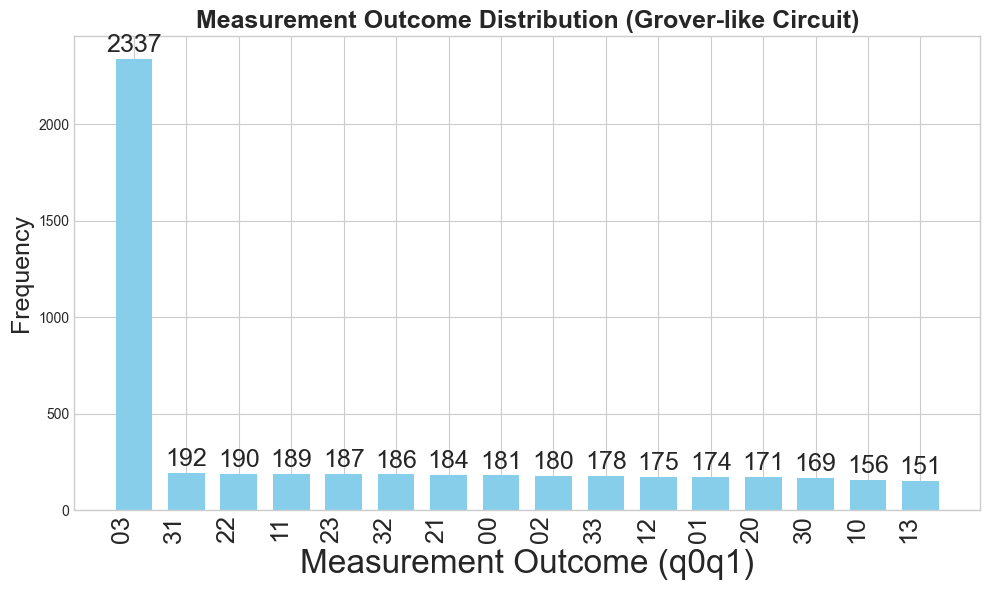

In [28]:
# --- Histogram Visualization ---

# Prepare data for plotting
# Sort by count (descending) to highlight the most frequent outcomes.
sorted_items_by_count = sorted(counts.items(), key=lambda item: item[1], reverse=True)
labels_by_count = [item[0] for item in sorted_items_by_count]
values_by_count = [item[1] for item in sorted_items_by_count]

# Set a visually pleasing style for the plot.
plt.style.use('seaborn-v0_8-whitegrid')

# Create the figure and axes for the plot.
fig, ax = plt.subplots(figsize=(10, 6)) # Adjust figure size for readability.

# Plot the bars of the histogram.
ax.bar(labels_by_count, values_by_count, color='skyblue', width=0.7)

# Add labels and a title for clarity.
ax.set_xlabel("Measurement Outcome (q0q1)", fontsize=24)
ax.set_ylabel("Frequency", fontsize=18)
ax.set_title("Measurement Outcome Distribution (Grover-like Circuit)", fontsize=18, fontweight='bold')

# Rotate x-axis labels to prevent overlap.
plt.xticks(rotation=90, ha='right', fontsize=18)

# Add value labels on top of each bar for exact counts.
for i, v in enumerate(values_by_count):
    ax.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=18)

# Improve layout to prevent elements from being cut off.
plt.tight_layout()

# Download the Image.
plt.savefig('Output/Grover like circuit.png')

# Display the plot.
plt.show()


In [17]:
# --- Circuit for constructing Grover's circuit with actual matrices ---

In [18]:
# Define the qubits. We are using cirq.LineQid to represent multi-level systems.
# q0 and q1 are 4-dimensional qudits.
q0 = cirq.LineQid(0, dimension=QU_DIMENSION)
q1 = cirq.LineQid(1, dimension=QU_DIMENSION)

In [19]:
#actual circuit

circuit = cirq.Circuit([
    QuditHGate(d=4)(q0),
    QuditHGate(d=4)(q1),
    UfGate()(q0,q1),
    QuditHGate(d=4)(q0),
    QuditHGate(d=4)(q1),
    U0Gate()(q0,q1),
    QuditHGate(d=4)(q0),
    QuditHGate(d=4)(q1),
    cirq.measure(q0, q1)
])

In [20]:
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=SIMULATION_REPETITIONS)

In [21]:
measurement_outcomes = result.measurements['q(0) (d=4),q(1) (d=4)'] # This will be a list of lists, e.g., [[0, 0], [1, 0], ...]
histogram_data = []
for outcome_pair in measurement_outcomes:
    # outcome_pair will be something like [0, 1] representing q0's result and q1's result
    # Convert each integer to its string representation and join them.
    histogram_data.append("".join(map(str, outcome_pair[::-1])))
counts = Counter(histogram_data)

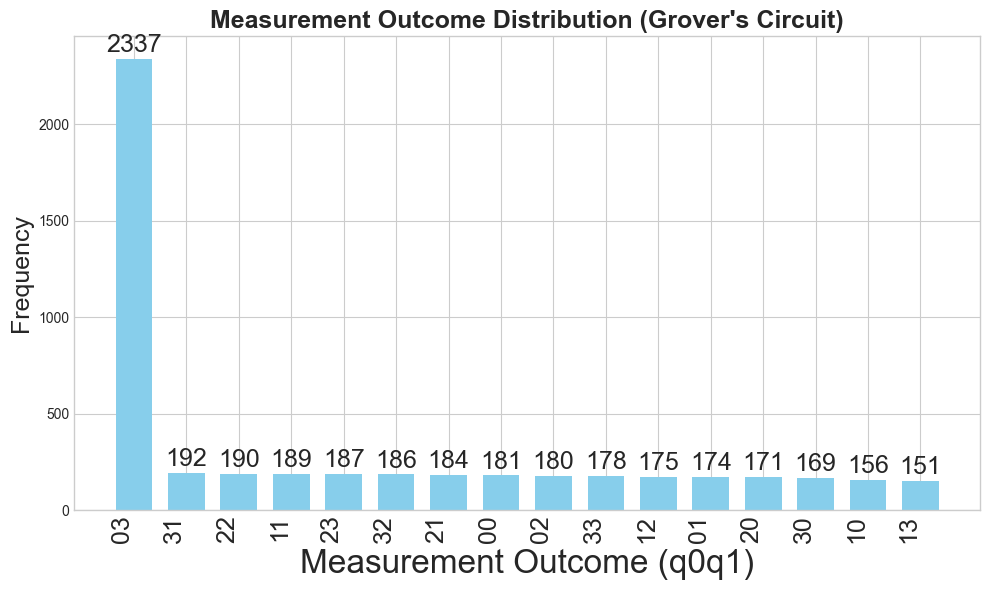

In [29]:
# --- Histogram Visualization ---

# Prepare data for plotting
# Sort by count (descending) to highlight the most frequent outcomes.
sorted_items_by_count = sorted(counts.items(), key=lambda item: item[1], reverse=True)
labels_by_count = [item[0] for item in sorted_items_by_count]
values_by_count = [item[1] for item in sorted_items_by_count]

# Set a visually pleasing style for the plot.
plt.style.use('seaborn-v0_8-whitegrid')

# Create the figure and axes for the plot.
fig, ax = plt.subplots(figsize=(10, 6)) # Adjust figure size for readability.

# Plot the bars of the histogram.
ax.bar(labels_by_count, values_by_count, color='skyblue', width=0.7)

# Add labels and a title for clarity.
ax.set_xlabel("Measurement Outcome (q0q1)", fontsize=24)
ax.set_ylabel("Frequency", fontsize=18)
ax.set_title("Measurement Outcome Distribution (Grover's Circuit)", fontsize=18, fontweight='bold')

# Rotate x-axis labels to prevent overlap.
plt.xticks(rotation=90, ha='right', fontsize=18)

# Add value labels on top of each bar for exact counts.
for i, v in enumerate(values_by_count):
    ax.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=18)

# Improve layout to prevent elements from being cut off.
plt.tight_layout()

# Download the Image.
plt.savefig('Output/Grover like circuit.png')

# Display the plot.
plt.show()

In [24]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
